# Applicability domains for models predicting properties of chemical reactions

* (c) 2020-2021 Assima Rakhimbekova
* updated 2021 Ramil Nugmanov

## Quantitative Reaction-Property Relationship (QRPR) models

The notebooks illustrates how the QRPR model can be used to predict rate constants of reactions and how we can
assess the reliability of the model's predictions using bimolecular nucleophilic substitution reactions dataset 
by [Gimadiev et al.](https://onlinelibrary.wiley.com/doi/abs/10.1002/minf.201800104) as an example.
* [Featurize the reactions using ISIDA fragment desciprots of Condensed Graph of Reactions](#Featurize-the-reactions-using-ISIDA-fragment-desciprots-of-Condensed-Graph-of-Reactions)
* [Train and predict QRPR model](#Train-and-predict-QRPR-model)
* [Train and predict models defining applicability domain of QRPR model](#Train-and-predict-models-defining-applicability-domain-of-QRPR-model)
    * [Bounding Box](#Bounding-Box)
    * [Fragment Control](#Fragment-Control)
    * [Reaction Type Control](#Reaction-Type-Control)
    * [Leverage](#Leverage)
    * [Z1NN](#Z1NN)
    * [Two Class X inlier/Y outlier Classifier](#Two-Class-X-inlier/Y-outlier-Classifier)
    * [GPR](#GPR)

Load dataset.

Dataset standardized by following workflow:
* kekule() - leads to kekule formula for benzene rings
* standardize() - standardize functional groups
* implicify_hydrogens() - removes hydrogens
* thiele() - aromatizes benzene rings (delocaslized bonds used).

In [1]:
from CIMtools.datasets import load_sn2

dataset, Y = load_sn2(return_X_y=True)

In [2]:
dataset[0]

Number of reactions and number of transformations

In [3]:
len(dataset), len(set(dataset))

(4830, 1352)

### Featurize the reactions using ISIDA fragment desciprots of Condensed Graph of Reactions

Chemical transformations are encoded by Condensed Graphs of Reaction (CGRs). ISIDA fragment descriptors are generated for the CGRs using the ISIDA Fragmentor program. We describe each solvent by 15 descriptors that represent polarity, polarizability, H-acidity and basicity: Catalan SPP, SA, and SB constants, Camlet–Taft constants α, β, and π*, four functions of the dielectric constant, three functions of the refractive index. We use the inverse absolute temperature, 1/T (in Kelvin degrees) as a descriptor of temperature. Since some of the solvents are water-organic mixtures, we use molar ratio of organic solvent as descriptor as well (100% for pure solvent). Descriptor vector for each reaction resulted from concatenation of structural descriptors and parameters describing experimental conditions (solvent and temperature). All descriptors are normalized to zero mean and unit variance.

In [4]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from os import environ
from CIMtools.preprocessing import Fragmentor, CGR, EquationTransformer, SolventVectorizer
from CIMtools.preprocessing.conditions_container import DictToConditions, ConditionsToDataFrame

def extract_meta(x):
    return [y[0].meta for y in x]

features = ColumnTransformer([('temp', EquationTransformer('1/x'), ['temperature']),
                              ('solv', SolventVectorizer(), ['solvent.1']),
                              ('amount', 'passthrough', ['solvent_amount.1']),])
conditions = Pipeline([('meta', FunctionTransformer(extract_meta)),
                       ('cond', DictToConditions(solvents=('additive.1',), 
                                                 temperature='temperature', 
                                                 amounts=('amount.1',))),
                       ('desc', ConditionsToDataFrame()),
                       ('final', features)])
graph = Pipeline([('CGR', CGR()), 
                  ('frg', Fragmentor(fragment_type=3, max_length=4, useformalcharge=True, version='2017')), 
                  ('scaler', StandardScaler())]) # All descriptors were normalized to zero mean and unit variance.

pp = ColumnTransformer([('cond', conditions, [0]),
                        ('graph', graph, [0])])

### Train and predict QRPR model

We use **Random Forest Regression** for building QRPR models

We use the nested cross-validation  procedure [Varma et al.](https://bmcbioinformatics.biomedcentral.com/articles/10.1186/1471-2105-7-91) to obtain a reliable assessment of predictive performance (*Figure 1*) and avoid overfitting. For each training/test split in the outer loop, the hyperparameters of **RandomForestRegressor** model are tuned using grid search by minimizing the averaged RMSE of prediction (without AD application) estimated in the inner cross-validation loop on the outer training set, and the optimal models with the tuned hyperparameters are used to predict reaction properties on the outer test set. 

<img src="img/Validation.png"/>

*Figure 1. The procedure for selecting the hyperparameters of QRPR and the AD definition models*

In [5]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, random_state=1, shuffle=True)

For simplicity, we will break on the first fold

In [6]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

Y_true, Y_pred = [], [] # collect all the values of logK
for train_index_ext, test_index_ext in kf.split(dataset):
    # external set
    reactions_train = dataset[train_index_ext]
    reactions_test = dataset[test_index_ext]
    x_train = pp.fit_transform(reactions_train.reshape(-1, 1))
    x_test = pp.transform(reactions_test.reshape(-1, 1))

    # predictable property is the rate constants of the reactions
    y_train = Y[train_index_ext]
    y_test = Y[test_index_ext]

    # inner cross-validation loop on the outer training set
    est = GridSearchCV(RandomForestRegressor(random_state=1, n_estimators=500),
                       {'max_features': [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 'auto', 'log2', None]},
                       cv=kf, verbose=1, scoring='neg_mean_squared_error', n_jobs=-1).fit(x_train, y_train)

    # predict logK values for test set
    y_pred = est.predict(x_test)
    Y_pred.extend(y_pred)
    Y_true.extend(y_test)
    break

Fitting 5 folds for each of 10 candidates, totalling 50 fits


Calculate performance metrics (R2, RMSE)

In [7]:
from sklearn.metrics import r2_score, mean_squared_error

r2_score(y_test, y_pred), mean_squared_error(y_test, y_pred, squared=False)

(0.8343407799923697, 0.46892451757515835)

Plot predicted vs experimental logK

In [8]:
import matplotlib.pyplot as plt


plt.rc('font', family='sans-serif')
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (7, 6),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

In [9]:
from numpy import arange,array,ones
from scipy import stats

def picture(name, y_test, y_pred, est, title, ad=None):
    slope, intercept, r_value, p_value, std_err = stats.linregress(y_pred, y_test)
    line = slope*np.array(y_pred)+intercept
    
    rmse = np.sqrt(-est.best_score_)
    fig=plt.figure()
    ax=fig.add_subplot(111, label="1")
    
    if name == 'without ad':
        ax.scatter(y_test, y_pred, color="blue", marker='.', s=150)
    else:
        # The reactions for which the absolute prediction error is higher than 3×RMSE are identified as Y-outliers, 
        # while the rest are considered as Y-inliers. This will be considered as true AD
        y_in_ad = abs(y_test-y_pred) <= 3*rmse
        for num, (ad_pred, ad_true) in enumerate(zip(ad, y_in_ad)):
            # We consider AD definition approaches as binary classifiers returning True 
            # for X-inliers (within AD) and False for X-outliers (outside AD). 
            if ad_pred == ad_true:
                if ad_pred == 0: # TN
                    ax.scatter(y_test[num], y_pred[num], color="red", marker='s', s=150)
                else: # TP
                    ax.scatter(y_test[num], y_pred[num], color="blue", marker='.')
            else:
                if ad_pred == 0: # FN
                    ax.scatter(y_test[num], y_pred[num], color="red", marker='^', s=150)
                else: # FP
                    ax.scatter(y_test[num], y_pred[num], color="blue", marker='+', s=250)
        labels = ['TN', 'TP', 'FN', 'FP']
        colors = ['red', 'blue', 'red', 'blue']
        markers = ['s', '.', '^', '+']
        for i in range(4):
            ax.scatter([], [], label=labels[i], color=colors[i], marker=markers[i], s=150)
        ax.legend()

    ax.set_xlabel("Experimental logK", color='black')
    ax.set_ylabel("Predicted logK", color='black')
    ax.set_title('{}'.format(title))

    plt.plot(line, y_pred, color='black', alpha=0.5)
    plt.plot(line-3*rmse, y_pred, 'k--', color='black', alpha=0.3)
    plt.plot(line+3*rmse, y_pred, 'k--', color='black', alpha=0.3)

    plt.grid(True)
    plt.rc('xtick') 
    plt.rc('ytick') 

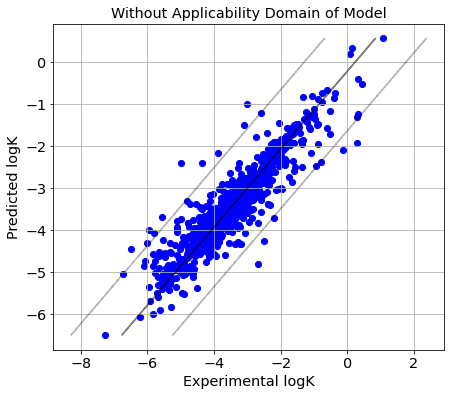

In [10]:
picture(name='without ad', y_test=Y_true, y_pred=Y_pred, est=est, title='Without Applicability Domain of Model')

## Train and predict models defining applicability domain of QRPR model

> QSAR/QSPR models are not universal, and their predictive performance highly depends on similarity to training
> examples [[Jaworska et al.](https://www.researchgate.net/publication/7498882_QSAR_applicabilty_domain_estimation_by_projection_of_the_training_set_descriptor_space_a_review), [Netzeva et al.](https://www.researchgate.net/publication/7583123_Current_Status_of_Methods_for_Defining_the_Applicability_Domain_of_Quantitative_Structure-Activity_Relationships-The_Report_and_Recommendations_of_ECVAM_Workshop_52)]. 
> Applicability Domain (AD) of a QSAR/QSPR model highlights a part of the chemical space containing those compounds 
> for which the model is supposed to provide reliable predictions [[Tetko et al.](https://pubs.acs.org/doi/abs/10.1021/ci800151m), [Sushko et al.](https://pubs.acs.org/doi/10.1021/ci100253r)]. So, the problem of determining AD of a model is closely related to the problem of assessing the reliability of its 
> predictions. According to the OECD (Organization of Economic Co-operation and Development) principles, QSAR/QSPR 
> models should have “defined an applicability domain” [[OICD](https://www.oecd-ilibrary.org/environment/guidance-document-for-the-development-of-oecd-guidelines-for-testing-of-chemicals_9789264077928-en)]. 
> 
> Although numerous approaches are considered in the literature to assess the AD for the models predicting the 
> properties of chemical compounds, ADs have almost never been applied to the models predicting characteristics of 
> chemical reactions, and the problem of AD definition for chemical reactions has never been discussed in the 
> literature. 
>
> It is much more difficult to define AD for the models aimed at predicting different characteristics of chemical 
> reactions in comparison with standard QSAR/QSPR models dealing with the properties of chemical compounds because it is necessary to consider several additional factors  (reaction representation, conditions, reaction type,  atom-to atom mapping, etc) that are specific for chemical reactions and should be taken into account. 

Therefore, the notebooks illustrates how we can assess the reliability of the model's predictions. We will show the various AD definition methods extensively used in QSAR/QSPR studies, their modifications, as well as novel approaches designed by us for reactions.

### Bounding Box

This approach defines AD as a D-dimensional hypercube with each edge spanning the range between the minimum and maximum values of the corresponding descriptor. If at least one descriptor for a given reaction is out of the range defined by the minimum and maximum values of the training set examples, the reaction is considered outside of the AD of the corresponding QRPR model (*Figure 2*). The method does not have adjustable hyperparameters.

<img src="img/Bounding_Box.png"/>

*Figure 2. Concept of Bounging Box, picture taken from [[S.Kar et al.]](https://pubmed.ncbi.nlm.nih.gov/29934891/)*


In [11]:
from CIMtools.applicability_domain import Box

AD_BB = Box().fit(x_train).predict(x_test)

In [12]:
AD_BB[:5]

array([ True,  True,  True,  True,  True])

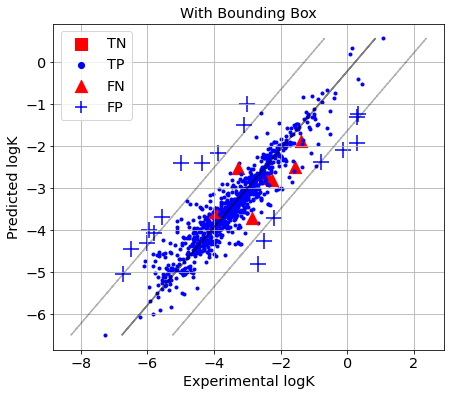

In [13]:
picture(name='with ad', y_test=y_test, y_pred=y_pred, est=est, title='With Bounding Box', ad=AD_BB)

### Fragment Control

The concept of Fragment Control present below (*Figure 3*).

<img src="img/Fragment_Control.png" />

*Figure 3. Concept of Fragment Control*

If a Condensed Graph of Reaction (*Figure 4*) representing a given reaction has fragments (subgraphs) missing in the training set, then it is considered to be an outlier (out of AD) whenever the corresponding QRPR model is applied. The method does not have adjustable hyperparameters.

The presented pipeline returns not only fragment descriptors, but also the AD in the last column. 
To do this you should add the parameter **return_domain=True**

In [14]:
AD_FC = Pipeline([('cgr', CGR()),
                  ('frg', Fragmentor(version='2017',
                                     max_length=4,
                                     useformalcharge=True,
                                     return_domain=True))]).fit(reactions_train).transform(reactions_test)

In [15]:
AD_FC.head(5)

,C-C,C-C=O,C-C-O&FC-1&,C1>0Clc-1,C0>1Oc+1&FC-1&-S,C0>1Oc+1&FC-1&-S=O,C0>1Oc+1&FC-1&-S-O&FC-1&,C0>1Oc+1&FC-1&,C=O,C-O&FC-1&,...,Br-C0>1Nc+1-C,F-C*C-O,Cl-C-C0>1Nc+1,Ic-11>0C0>1O,O0>1C-C=O,O-C-C0>1O,C0>1O0>1C1>0Ic-1,I-C0>1Oc+1&FC-1&,C-Oc+1&FC-1&0>1C-I,AD
0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True
1,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True
2,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True
3,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True
4,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True


In [16]:
AD_FC.AD.values[:5]

array([ True,  True,  True,  True,  True])

> The reactions for which the absolute prediction error is higher than 3×RMSE are identified as Y-outliers, while the rest are considered as Y-inliers. Y-Outliers (poorly predicted) that are predicted by AD definition as X-outliers
> (outside AD) are called true outliers (TN), while Y-inliers predicted by AD definition as X-inliers (within AD) are  called true inliers (TP). False outliers (FN) are Y-inliers that are wrongly predicted by the AD definition as 
> X-outliers, while false inliers (FP) are Y-outliers that are wrongly predicted by the AD definition as X-inliers.

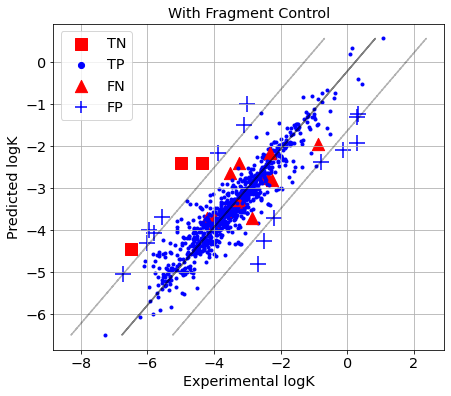

In [17]:
picture(name='with ad', y_test=y_test, y_pred=y_pred, est=est, title='With Fragment Control', ad=AD_FC.AD.values)

### Reaction Type Control

If the reaction centre of a chemical reaction is absent in the reactions in the training set, it is considered out of AD (X-outlier). Reaction centre is detected using reaction signatures [Nugmanov et al](https://pubs.acs.org/doi/10.1021/acs.jcim.9b00102). Signature creation includes (*Figure 4*)
* (1) representation of a chemical reaction as a **Condensed Graph of Reaction** (CGR), 
* (2) highlight one or more reaction centers which are identified as a set of adjacent dynamic atoms and bonds on the CGR
* (3) environment atoms of a certain radius R for each of the reaction centers, 
* (4) introducing canonical numbering of atoms of the reaction center with the environment using an algorithm similar to the Morgan algorithm, 
* (5) the signature is encoded by SMILES-like canonical string generated by CGRtools library [Nugmanov et al](https://pubs.acs.org/doi/10.1021/acs.jcim.9b00102). 

For every atom hybridization and element label, as well as bond order is encoded in a signature. Since the method does not consider the whole structure, but only its reaction center with its closest environment, in order to be able to distinguish whether the aromatic cycle is part of the reaction center or its closest substituent, we introduced a separate type of hybridization for aromatic carbon atoms. We also used sp3, sp2, sp hybridization to describe the hybridization of not aromatic atoms. Hence, the signature includes information both on the reaction centre itself and its closest environment of radius R. The radius of environment included into the signature is a hyperparameter of the method. If the environment is set to 0, the reaction signature includes only atoms of the reaction centre.

<img src="img/Reaction_Type_Control.png" />

*Figure 4. The chemical reaction (top left), its Condensed Graph of Reaction (top centre) and the reaction centre with R=1 (top right). Colour lines on CGR represent dynamic bonds. Indices “0>>–” and “0>>+” on CGR mean that atomic charges are lowered from 0 to -1 and increased from 0 to +1, respectively. Indices “1>>0” and 1>>1” on the reaction center mean changes in the number of neighbors, letters – hybridization changes (“s” – sp3, “a” - atom is in the aromatic ring). The signature of the reaction center with R=1 is shown bottom*

Let's find the optimal radius. For this reason, we need to use **rtc_env_selection function from CIMtools.model_selection**

> To build the best AD definition models, it is necessary to optimize their thresholds and (hyper)parameters by 
> maximizing some AD performance metric. We will use a following metric:
>
>**'ba_ad'** - the Outliers Criterion metric which shows how well AD definition detects Y-outliers. First, property 
> prediction errors are estimated in cross-validation for all reactions in a dataset. The reactions for which the 
> absolute prediction error is higher than 3×RMSE are identified as Y-outliers, while the rest are considered as 
> Y-inliers. Y-Outliers (poorly predicted) that are predicted by AD definition as X-outliers (outside AD) are called true outliers (TO), while Y-inliers predicted by AD definition as X-inliers (within AD) are called true inliers 
> (TI). False outliers (FO) are Y-inliers that are wrongly predicted by the AD definition as X-outliers, while false  inliers (FI) are Y-outliers that are wrongly predicted by the AD definition as X-inliers. Then quality of 
> outliers/inliers determination can be assessed using an analogue of the balanced accuracy and denoted as OD 
> (Outliers Detection). OD = (TO/(TO+FI)+TI/(TI+FO))/2.

In [18]:
from CIMtools.model_selection import rtc_env_selection

best_r = rtc_env_selection(X=x_train, y=y_train, data=reactions_train, envs=[0, 1, 2], 
                           reg_model=est.best_estimator_, score='ba_ad') 
# as you can see we use only the training set for optimize their thresholds and (hyper)parameters

In [19]:
best_r

2

In [20]:
from CIMtools.applicability_domain import ReactionTypeControl

AD_RTC_cv = ReactionTypeControl(env=best_r).fit(reactions_train).predict(reactions_test)

In [21]:
AD_RTC_cv[:5]

array([ True,  True,  True,  True,  True])

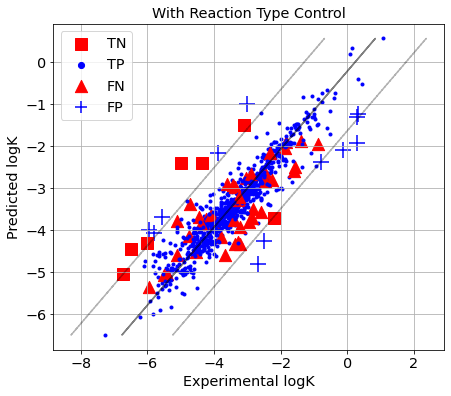

In [22]:
picture(name='with ad', y_test=y_test, y_pred=y_pred, est=est, title='With Reaction Type Control', ad=AD_RTC_cv)

### Leverage

This method is based on the Mahalanobis distance to the centre of the training-set distribution. The leverage h of a chemical reaction is calculated based on the “hat” matrix as h=(xiT(XTX)-1xi), where X is the training-set descriptor matrix, and xi is the descriptor vector for the reaction i. The leverage threshold is usually defined as h**=3*(M+1)/N, where M is the number of descriptors and N is the number of training examples. Chemical reactions with leverage values h > h* are considered to be chemically different from the training-set reactions, so they are marked as X-outliers (*Figure 5*).

<img src="img/Leverage.png"/>

*Figure 5. The extrapolation regions of distance-to-centroid plot, picture taken from [[S.Kar et al.]](https://pubmed.ncbi.nlm.nih.gov/29934891/)*


In [23]:
from CIMtools.applicability_domain import Leverage

leverage_model = Leverage(threshold='auto').fit(x_train, y_train)

An illustrative example of the leverage. Leverage penalizes the compounds that are far from the center of the training set in the space of molecular descriptors. According to leverage, such compounds are unreliably predicted (picture from dissertation I.Sushko)

In [24]:
AD_Leverage = leverage_model.predict(X=x_test)

In [25]:
AD_Leverage[:5]

array([ True,  True,  True,  True,  True])

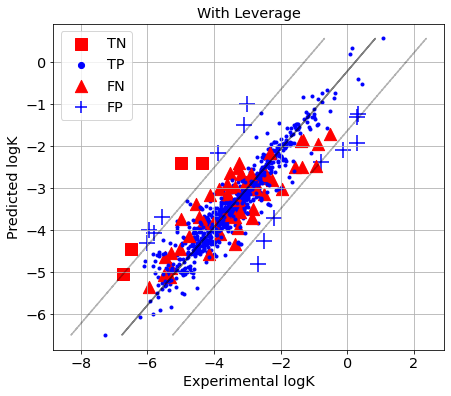

In [26]:
picture(name='with ad', y_test=y_test, y_pred=y_pred, est=est, title='With Leverage', ad=AD_Leverage)

if you want to predict the distances for X to center of the training set, you should write

In [27]:
leverage_model.predict_proba(x_test)[:5]

array([0.04156393, 0.01981549, 0.01466677, 0.01482889, 0.01524357])

**The drawback of it is the absence of strict rules for choosing the threshold h. As an alternative, an optimal threshold value h can be found using an internal cross-validation procedure by maximizing ba_ad.**

In [28]:
AD_Lev_cv = Leverage(threshold='cv', score='ba_ad', 
                     reg_model=est.best_estimator_).fit(x_train, y_train).predict(x_test)

In [29]:
AD_Lev_cv[:5]

array([ True,  True,  True,  True,  True])

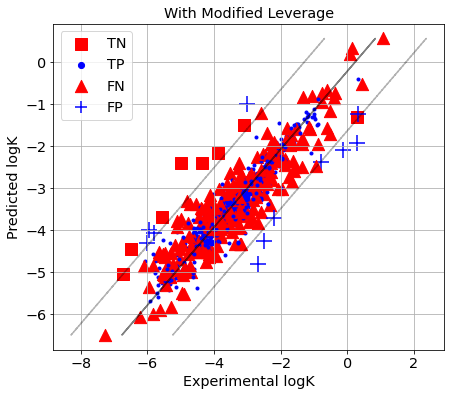

In [30]:
picture(name='with ad', y_test=y_test, y_pred=y_pred, est=est, title='With Modified Leverage', ad=AD_Lev_cv)

### Z1NN

This AD definition is based on the distance(s) between a current reaction and the closest training-set reaction(s). Usually, one nearest neighbour is considered (k=1). If the distance is not within the user-defined threshold, then the prediction is considered unreliable and the reaction is considered as X-outlier. The threshold value is commonly taken as Dc=Zσ+y, where y is the average and σ is the standard deviation of the Euclidean distances between nearest neighbours in the training set, Z is an empirical parameter to control the significance level, with the recommended value of 0.5 (*Figure 6*).

<img src="img/Z1NN.png"/>

*Figure 6. K-nearest neighbors plot, picture taken from [[S.Kar et al.]](https://pubmed.ncbi.nlm.nih.gov/29934891/)*

In [31]:
from CIMtools.applicability_domain import SimilarityDistance

Z1NN_model = SimilarityDistance(threshold='auto').fit(x_train, y_train)

In [32]:
AD_Z1NN = Z1NN_model.predict(x_test)

In [33]:
AD_Z1NN[:5]

array([ True,  True,  True,  True,  True])

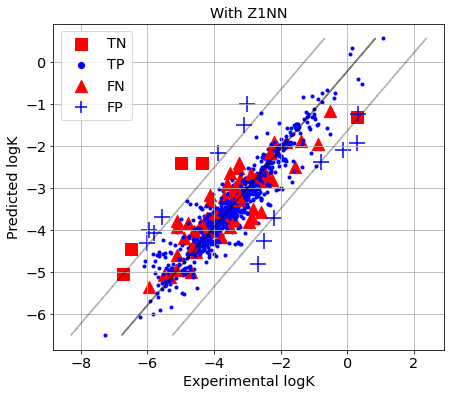

In [34]:
picture(name='with ad', y_test=y_test, y_pred=y_pred, est=est, title='With Z1NN', ad=AD_Z1NN)

Returns the value of the nearest neighbor from the training set.

In [35]:
Z1NN_model.predict_proba(x_test)[:5]

array([1.02001345e-04, 5.53194200e-05, 2.90006968e-01, 1.60658619e-04,
       3.06629569e-04])

An optimal threshold can be found using an internal cross-validation procedure by maximizing **ba_ad**.

In [36]:
AD_Z1NN_cv = SimilarityDistance(score='ba_ad', threshold='cv', 
                                reg_model=est.best_estimator_).fit(x_train, y_train).predict(x_test)

In [37]:
AD_Z1NN_cv[:5]

array([ True,  True, False,  True, False])

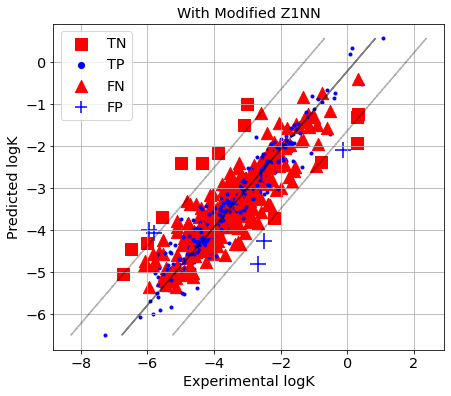

In [38]:
picture(name='with ad', y_test=y_test, y_pred=y_pred, est=est, title='With Modified Z1NN', ad=AD_Z1NN_cv)

### Two Class X inlier/Y outlier Classifier

In this case, a binary classifier learns to distinguish Y-inliers from Y-outliers. First, QRPR models are built to predict quantitative characteristics of chemical reactions. Chemical reactions with higher prediction error estimated in cross-validation (more than 3×RMSE) are labelled as Y-outliers, while the remaining reactions are labelled as Y-inliers. After that, a binary classification model is trained to discriminate between them and provide a confidence score that a given reaction is a Y-inlier for the corresponding QRPR model. Although this method seems quite straightforward, we have not found its application in literature. Unfortunately, this method cannot be applied if there are no or too few Y-outliers. We use Random Forest Classifier for building the binary classification model. The method requires setting the values of two hyperparameters: max_features (the values of features selected upon tree branching) and probability threshold P. If the predicted probability of belonging to the X-inliers is greater than P, the prediction of reaction characteristics by the QRPR model for it is considered reliable (within AD)

In [39]:
from CIMtools.applicability_domain import TwoClassClassifiers
from sklearn.ensemble import RandomForestClassifier

AD_2CC = TwoClassClassifiers(threshold='cv', score='ba_ad', reg_model=est.best_estimator_, 
                             clf_model=RandomForestClassifier(n_estimators=500, random_state=1)).fit(x_train, y_train).predict(x_test)

In [40]:
AD_2CC[:5]

array([ True,  True,  True,  True,  True])

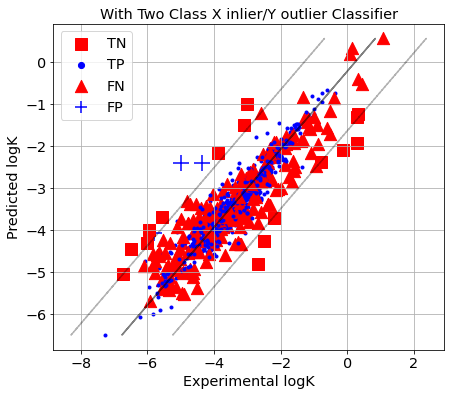

In [41]:
picture(name='with ad', y_test=y_test, y_pred=y_pred, est=est, title='With Two Class X inlier/Y outlier Classifier', 
        ad=AD_2CC)

### 1-SVM

The one-class Support Vector Method reveals highly populated zones in descriptor space by maximizing the distance between a separating hyperplane and the origin in the feature space implicitly defined by some Mercers’ kernel. The decision function of such model returns (+1) for the reactions which fall into highly populated zones (within AD, i.e. X-inliers) and (−1) - for the reactions outside of AD (X-outliers). The method requires the fitting of two hyperparameters: nu (which defines the upper bound percentage of errors and lower bound percentage of support vectors) and gamma (parameter of RBF kernel which is used), the optimal values of which can be found in iternal cross-validation

The following function is required for making make_scorer

In [42]:
from sklearn.metrics import mean_squared_error, balanced_accuracy_score

def balanced_accuracy_score_with_ad(Y_pred_test, AD_pred):
    AD_true = abs(Y_pred_test[:, 0] - Y_pred_test[:, 1]) <= 3 * np.sqrt(mean_squared_error(Y_pred_test[:, 1],
                                                                                          Y_pred_test[:, 0]))
    return balanced_accuracy_score(AD_true, AD_pred)

In [43]:
import numpy as np
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import make_scorer
from sklearn.svm import OneClassSVM

Y_predicted = cross_val_predict(RandomForestRegressor(random_state=1, n_estimators=500, 
                                                      max_features=est.best_params_['max_features']), 
                                x_train, y_train, cv=kf, verbose=1, n_jobs=-1)
Y_pr_ts = np.column_stack((Y_predicted, y_train)) # it needs for GridSearchCV
scorer_for_svm = make_scorer(balanced_accuracy_score_with_ad, greater_is_better=True)
AD_SVM = GridSearchCV(OneClassSVM(), {'nu': [0.05, 0.1, 0.15, 0.2, 0.25, 0.3,],
                                       'gamma': [1e-3, 1e-2, 1e-1, 1, 10,]},
                       cv=kf, verbose=1, scoring=scorer_for_svm, n_jobs=-1).fit(x_train, Y_pr_ts).predict(x_test)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   23.3s remaining:   34.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   29.5s finished


Fitting 5 folds for each of 30 candidates, totalling 150 fits


In [44]:
AD_SVM[:5]

array([1, 1, 1, 1, 1])

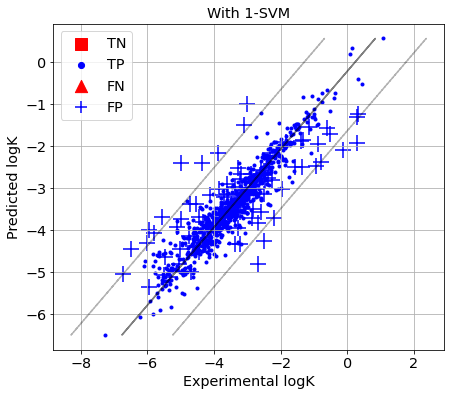

In [45]:
picture(name='with ad', y_test=y_test, y_pred=y_pred, est=est, title='With 1-SVM', ad=AD_SVM)

### GPR

**Gaussian Process Regression (GPR)** assumes that the joint distribution of a real-valued property of chemical reactions and their descriptors is multivariate normal (Gaussian) with the elements of its covariance matrix computed by means of special covariance functions (kernels). For every reaction, a GPR model produces using the Bayes’ theorem a posterior conditional distribution (so-called prediction density) of the reaction property given the vector of reaction descriptors. The prediction density has normal (Gaussian) distribution with the mean corresponding to predicted value of the property and the variance corresponding to prediction confidence. If the variance is greater than a predefined threshold σ, the chemical reaction is considered as X-outlier (out of AD). The method requires adjustment of three hyperparameter - alpha which stands for the noise level (also acts as regularization of the model), the parameter gamma of the RBF kernel which represents the covariance function and variance threshold σ. The optimal values of hyperparameters are determined using internal cross-validation.

In [46]:
from CIMtools.applicability_domain import GPR_AD

AD_GPR = GPR_AD(threshold='cv', score='ba_ad').fit(x_train, y_train).predict(x_test)

/home/stsouko/bydlocoding/CGRtools/env/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:375: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/stsouko/bydlocoding/CGRtools/env/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:375: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/stsouko/bydlocoding/CGRtools/env/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:375: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/stsouko/bydlocoding/CGRtools/env/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:375: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/stsouko/bydlocoding/CGRtools/env/lib/p

In [47]:
AD_GPR[:5]

array([ True,  True, False,  True,  True])

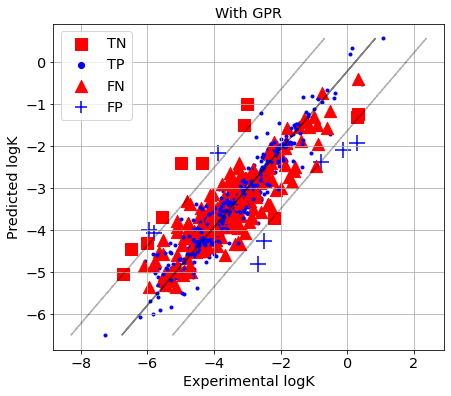

In [48]:
picture(name='with ad', y_test=y_test, y_pred=y_pred, est=est, title='With GPR', ad=AD_GPR)

And so we go through the remaining 4 folds. 
Then we collect all the results and calculate the characteristics...
